##### Importing libraries for the project

In [10]:
# Libraries for JSON operations
import requests
import os
import csv
import json

# Libraries for Database operations
import mysql.connector

# Libraries for Dataset operations
import pandas as pd

# Libraries for plotting operations
import seaborn as sns
import matplotlib.pyplot as plt

# Liraries for prediction
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score 

##### Function to fetch air quality data for a given location

In [11]:
def get_air_quality_data(latitude, longitude, start_date, end_date):
    """
    - Function to fetch air quality data for specific date range for a given location 
    - It accepts 4 parameters: latitude and longitude for given location, start_date and end_date
      for selecting a time range
    - It returns data received from the Open Meteo API
    """

    # Show an error message in case there is no location present
    if not latitude or not longitude:
        print("Error: No Location found")
        return None
    
    # Show an error message in case there is no date range present
    if not start_date or not end_date:
        print("Error: No date was present")
        return None

    open_meteo_url = f"https://air-quality-api.open-meteo.com/v1/air-quality?latitude={latitude}&longitude={longitude}&current=european_aqi&hourly=pm10,pm2_5,carbon_monoxide,carbon_dioxide,nitrogen_dioxide,sulphur_dioxide,ozone,aerosol_optical_depth,dust,uv_index,uv_index_clear_sky,methane&timezone=auto&start_date={start_date}&end_date={end_date}"
    
    try:
        response = requests.get(open_meteo_url)
    except:
        # Handling of the case if due to some issue API call fails to the Open Meteo API server
        print("Error: Request failed to the Open Meteo API Server. Try Again")
        return None
    
    json_data = response.json()

    return json_data["hourly"]

##### Create a CSV file from the API response

In [12]:
def create_csv_for_air_quality_data(latitude, longitude, start_date, end_date, file_name):
    """
    - Function to create a CSV file containing information about pollutants affecting air quality
      for a specific region for a given time frame
    - It accepts 5 parameters: latitude and longitude for given location, start_date and end_date
      for selecting a time range and file_name for storing the data into CSV file
    - It returns None 
    """

    # Fetch air quality data for the specified location
    air_quality_data = get_air_quality_data(latitude, longitude, start_date, end_date)

    data_rows = []

    # For each timeslot prepare a new row/record to be inserted into the CSV file 
    for i in range(len(air_quality_data["time"])):
        row = [air_quality_data["time"][i], air_quality_data["pm10"][i], air_quality_data["pm2_5"][i],
               air_quality_data["carbon_monoxide"][i], air_quality_data["carbon_dioxide"][i],
               air_quality_data["nitrogen_dioxide"][i], air_quality_data["sulphur_dioxide"][i],
               air_quality_data["ozone"][i], air_quality_data["aerosol_optical_depth"][i], air_quality_data["dust"][i],
               air_quality_data["uv_index"][i], air_quality_data["uv_index_clear_sky"][i], 
               air_quality_data["methane"][i]]
        data_rows.append(row)
    
    csv_file_name = file_name
    csv_headers = list(air_quality_data.keys())

    # Write the data into a CSV file
    try:
        with open(csv_file_name, mode="w", newline="") as file:
            writer = csv.writer(file)
            writer.writerow(csv_headers)
            writer.writerows(data_rows)
    except Exception as error:
        print("Something went wrong: ", error)

##### Create the CSV file and a dataframe object

In [13]:
# Location for the state - New Delhi
latitude = 28.6358
longitude = 77.2245

# Date range selected is 1st January, 2023 to 31st December, 2023
start_date = "2023-01-01"
end_date = "2023-12-31"
file_name = "air_quality.csv"

# Create CSV file for air quality data for "New Delhi"
create_csv_for_air_quality_data(latitude, longitude, start_date, end_date, file_name)

# Create the dataframe object from the CSV file
df = pd.read_csv("air_quality.csv")

##### Saving initial data in a MySQL Database

In [14]:
def save_data_into_dbms(df, table_name, custom_fields=False):
    """
    - Function to save dataframe object into an appropriate Database
    - It accepts 3 parameters: dataframe object from which data needs to be extracted and 
      table name within which the data will be stored and custom_field boolean flag which tells
      to only save some specific fields
    - It returns None 
    """
    
    try:
        # Build connection with MySQL Server
        connection = mysql.connector.connect(
            host=os.getenv("SQL_HOST"),
            user=os.getenv("SQL_USERNAME"),
            password=os.getenv("SQL_PASSWORD"),
            port=os.getenv("SQL_PORT")
        )

        cursor = connection.cursor()
        db_name = "air_quality_monitoring_db"

        # Create the database if not exists
        cursor.execute(f"CREATE DATABASE IF NOT EXISTS {db_name}")
        cursor.execute(f"USE {db_name}")

        # # If custom fields is True, we dont want to save values for carbon dioxide, uv_index_clear_sky and methane
        if custom_fields:
            cursor.execute(f"""CREATE TABLE {table_name} (
                time DATETIME, pm10 FLOAT NULL, pm2_5 FLOAT NULL, carbon_monoxide FLOAT NULL,
                nitrogen_dioxide FLOAT NULL, sulphur_dioxide FLOAT NULL, ozone FLOAT NULL, aerosol_optical_depth FLOAT NULL,
                dust FLOAT NULL, uv_index FLOAT NULL
            )""")

            # for each record within the dataframe, insert that into SQL table
            for index, row in df.iterrows():
                query = f"""INSERT INTO {table_name} (
                    time, pm10, pm2_5, carbon_monoxide, nitrogen_dioxide, sulphur_dioxide,
                    ozone, aerosol_optical_depth, dust, uv_index
                ) VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
                """

                cursor.execute(query, (
                    row["time"], row["pm10"], row["pm2_5"], row["carbon_monoxide"],
                    row["nitrogen_dioxide"], row["sulphur_dioxide"], row["ozone"], row["aerosol_optical_depth"],
                    row["dust"], row["uv_index"]
                ))
        else:
            cursor.execute(f"""CREATE TABLE {table_name} (
                time DATETIME, pm10 FLOAT NULL, pm2_5 FLOAT NULL, carbon_monoxide FLOAT NULL, carbon_dioxide FLOAT NULL,
                nitrogen_dioxide FLOAT NULL, sulphur_dioxide FLOAT NULL, ozone FLOAT NULL, aerosol_optical_depth FLOAT NULL,
                dust FLOAT NULL, uv_index FLOAT NULL, uv_index_clear_sky FLOAT NULL, methane FLOAT NULL
            )""")

            # for each record within the dataframe, insert that into SQL table
            for index, row in df.iterrows():
                query = f"""INSERT INTO {table_name} (
                    time, pm10, pm2_5, carbon_monoxide, carbon_dioxide, nitrogen_dioxide, sulphur_dioxide,
                    ozone, aerosol_optical_depth, dust, uv_index, uv_index_clear_sky, methane
                ) VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
                """

                cursor.execute(query, (
                    row["time"], row["pm10"], row["pm2_5"], row["carbon_monoxide"], row["carbon_dioxide"],
                    row["nitrogen_dioxide"], row["sulphur_dioxide"], row["ozone"], row["aerosol_optical_depth"],
                    row["dust"], row["uv_index"], row["uv_index_clear_sky"], row["methane"]
                ))

        connection.commit()
    
        # Close the connection
        cursor.close()
        connection.close()

        print("Successfully created table for air quality inside the database")
    except Exception as error:
        print("Could not perform saving data in the SQL table: ", error)

##### Saving the data into a Database before pre-processing

In [15]:
df = df.replace({pd.NA: None, pd.NaT: None, float('nan'): None})
save_data_into_dbms(df, "air_quality")

Successfully created table for air quality inside the database


## Cleaning Dataset (Preprocessing and Transformation)

##### Data Characteristics

In [16]:
# Print the number of records and features within the dataset
print(df.shape)
print("------------------")

# Print the feature names of the dataset
print(df.columns)
print("------------------")

# Print the top 5 rows of the dataset
print(df.head())

(8760, 13)
------------------
Index(['time', 'pm10', 'pm2_5', 'carbon_monoxide', 'carbon_dioxide',
       'nitrogen_dioxide', 'sulphur_dioxide', 'ozone', 'aerosol_optical_depth',
       'dust', 'uv_index', 'uv_index_clear_sky', 'methane'],
      dtype='object')
------------------
               time   pm10 pm2_5 carbon_monoxide carbon_dioxide  \
0  2023-01-01T00:00  136.4  87.5          1965.0           None   
1  2023-01-01T01:00  135.0  87.5          1708.0           None   
2  2023-01-01T02:00  134.1  87.8          1427.0           None   
3  2023-01-01T03:00  136.9  90.8          1290.0           None   
4  2023-01-01T04:00  140.6  94.1          1195.0           None   

  nitrogen_dioxide sulphur_dioxide ozone aerosol_optical_depth  dust uv_index  \
0             63.7            39.6  18.0                  0.36  31.0      0.0   
1             64.2            38.3  17.0                  0.37  28.0      0.0   
2             64.1            37.1  17.0                  0.38  24.0     

##### Data Types Handling

In [17]:
# Handle Data types
print(df.dtypes) 
print("----------------------------")

# Converting time into datetime object instead of string format
df["time"] = pd.to_datetime(df["time"])

print(df.dtypes)

time                     object
pm10                     object
pm2_5                    object
carbon_monoxide          object
carbon_dioxide           object
nitrogen_dioxide         object
sulphur_dioxide          object
ozone                    object
aerosol_optical_depth    object
dust                     object
uv_index                 object
uv_index_clear_sky       object
methane                  object
dtype: object
----------------------------
time                     datetime64[ns]
pm10                             object
pm2_5                            object
carbon_monoxide                  object
carbon_dioxide                   object
nitrogen_dioxide                 object
sulphur_dioxide                  object
ozone                            object
aerosol_optical_depth            object
dust                             object
uv_index                         object
uv_index_clear_sky               object
methane                          object
dtype: object


##### Handling Missing Values

In [18]:
# Check for missing values in each column
missing_values = df.isnull().sum()
print("Before filling the missing values")
print(missing_values)
print("---------------------------")

# Since features "carbon_dioxide" and  "methane" all has missing values, dropping the features
df = df.drop("carbon_dioxide", axis=1)
df = df.drop("methane", axis=1)

missing_values = df.isnull().sum()
print("After filling the missing values")
print(missing_values)
print("---------------------------")

Before filling the missing values
time                        0
pm10                        0
pm2_5                       0
carbon_monoxide             0
carbon_dioxide           8760
nitrogen_dioxide            0
sulphur_dioxide             0
ozone                       0
aerosol_optical_depth       0
dust                        0
uv_index                    0
uv_index_clear_sky          0
methane                  8760
dtype: int64
---------------------------
After filling the missing values
time                     0
pm10                     0
pm2_5                    0
carbon_monoxide          0
nitrogen_dioxide         0
sulphur_dioxide          0
ozone                    0
aerosol_optical_depth    0
dust                     0
uv_index                 0
uv_index_clear_sky       0
dtype: int64
---------------------------


##### Handling Duplicate Values and Outliers

Number of duplicate rows within the dataset before removal: 0


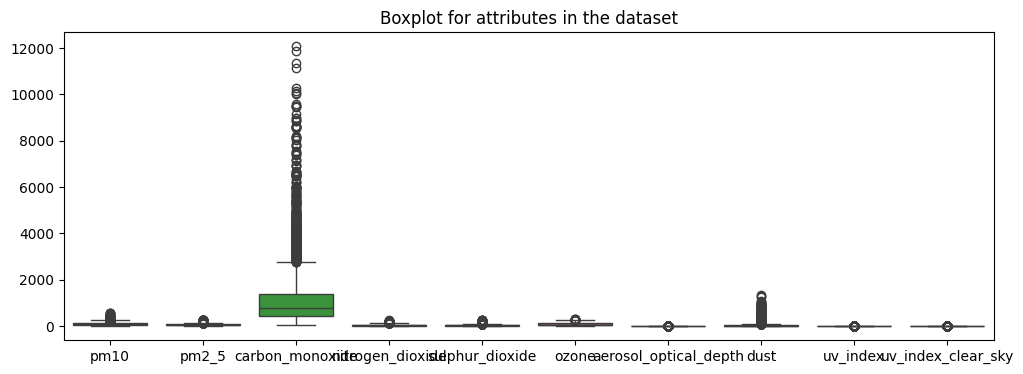

In [19]:
duplicate_rows = df[df.duplicated()]
print("Number of duplicate rows within the dataset before removal: " + str(duplicate_rows.shape[0]))
# Output - 0 (No dupkicates found)

# Box plot visualization to find outliers
plt.figure(figsize=(12, 4))
sns.boxplot(data=df)
plt.title("Boxplot for attributes in the dataset")
plt.show()
# Even though it shows outliers within the "carbon_monoxide" feature, we cannot remove those records as
# it will lead to data loss for that particular time of data which can be crucial

##### Find Correlations among the features

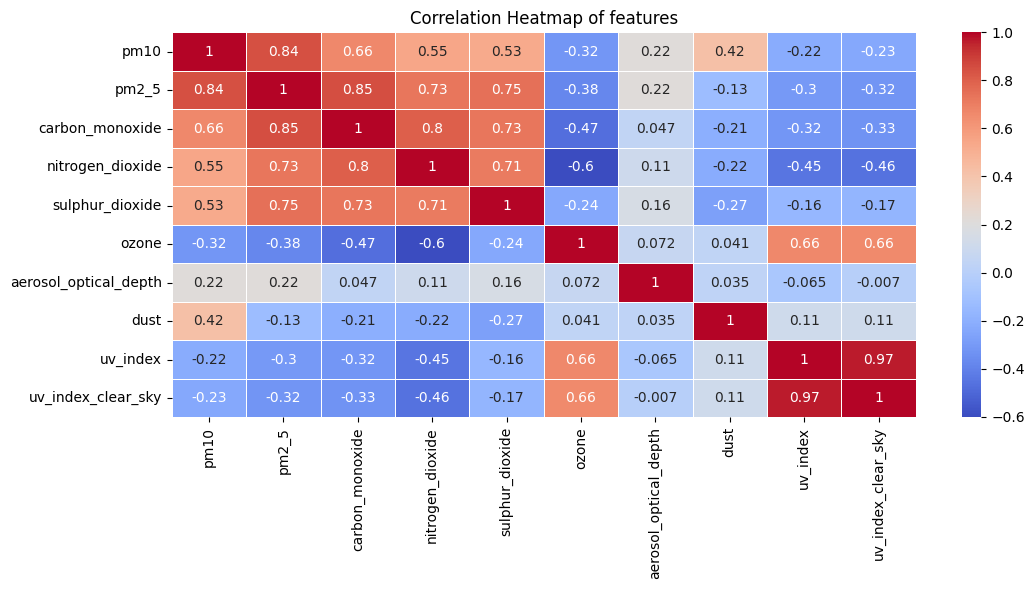

In [20]:
X = df.drop("time", axis=1)

plt.figure(figsize=(12, 5))
sns.heatmap(X.corr(), annot=True, cmap="coolwarm", linewidths=0.5)
plt.title('Correlation Heatmap of features')
plt.show()

##### Removing unwanted items from Dataset

In [21]:
# Since "uv_index" and "uv_index_clear_sky" shows almost same records as well as shows same corrrelations with other
# features and hence one of them can be removed from the dataset
df = df.drop("uv_index_clear_sky", axis=1)

##### Converting the corrected dataframe object into a correct CSV file

In [23]:
df.to_csv("air_quality_transformed.csv")

# Data Visualization

C:\Users\karan\AppData\Local\Temp\ipykernel_28776\4245752196.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="season", y="pm2_5", data=seasonal_data, palette="coolwarm")


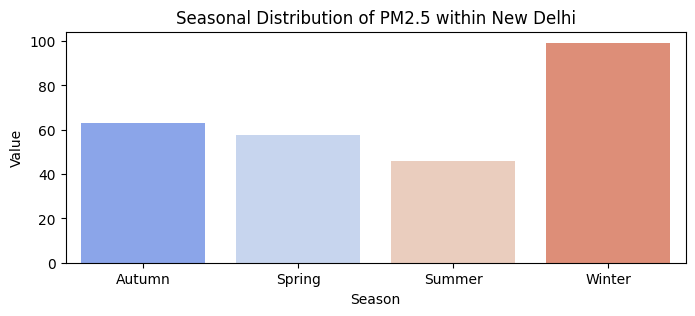

In [26]:
def get_season_name(month):
    """
    - Function takes a month number and returns the season name in which that month falls
    - It takes 1 parameter month number
    - It returns the name of the season that month falls into
    """
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    else:
        return "Autumn"

# Add season name to the dataframe for visualization
df_season = df.copy()
df_season["month"] = df_season["time"].dt.month
df_season["season"] = df_season["month"].apply(get_season_name)

# Group by season and calculate the mean for pollutants
seasonal_data = df_season.groupby("season")[["pm2_5"]].mean()
plt.figure(figsize=(8, 3))
sns.barplot(x="season", y="pm2_5", data=seasonal_data, palette="coolwarm")
plt.title("Seasonal Distribution of PM2.5 within New Delhi")
plt.ylabel("Value")
plt.xlabel("Season")
plt.show()

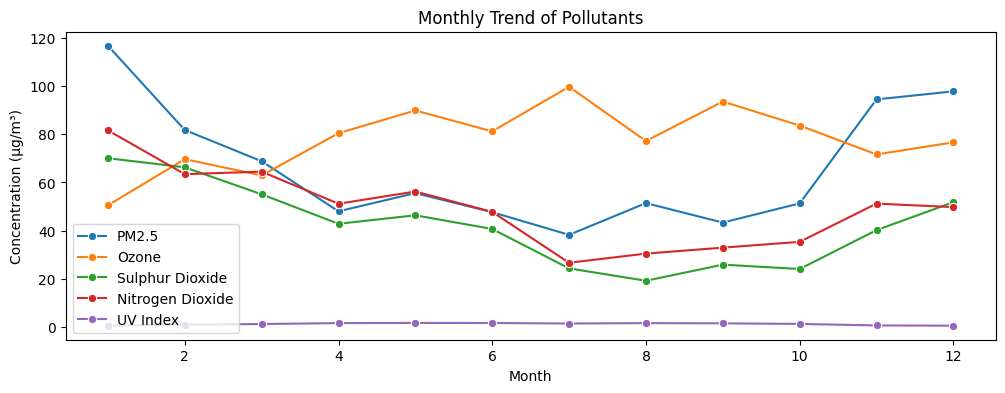

In [27]:
# Group by month and calculate the mean of pollutants
pollutants = ["pm2_5", "ozone", "sulphur_dioxide", "nitrogen_dioxide", "uv_index"]
monthly_avg = df_season.groupby("month")[pollutants].mean()

plt.figure(figsize=(12, 4))

sns.lineplot(data=monthly_avg, x="month", y="pm2_5", marker="o", label="PM2.5")
sns.lineplot(data=monthly_avg, x="month", y="ozone", marker="o", label="Ozone")
sns.lineplot(data=monthly_avg, x="month", y="sulphur_dioxide", marker="o", label="Sulphur Dioxide")
sns.lineplot(data=monthly_avg, x="month", y="nitrogen_dioxide", marker="o", label="Nitrogen Dioxide")
sns.lineplot(data=monthly_avg, x="month", y="uv_index", marker="o", label="UV Index")

plt.title("Monthly Trend of Pollutants")
plt.xlabel("Month")
plt.ylabel("Concentration (µg/m³)")
plt.show()


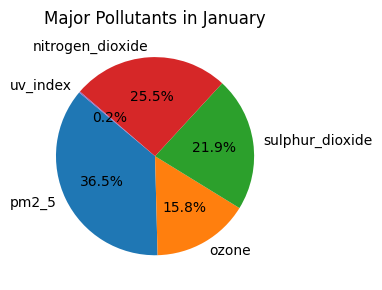

In [28]:
pollutants = ["pm2_5", "ozone", "sulphur_dioxide", "nitrogen_dioxide", "uv_index"]
january_data = df_season[df_season["month"] == 1][pollutants].mean()

plt.figure(figsize=(8, 3))
plt.pie(january_data, labels=pollutants, autopct="%1.1f%%", startangle=140)
plt.title("Major Pollutants in January")
plt.tight_layout()
plt.show()

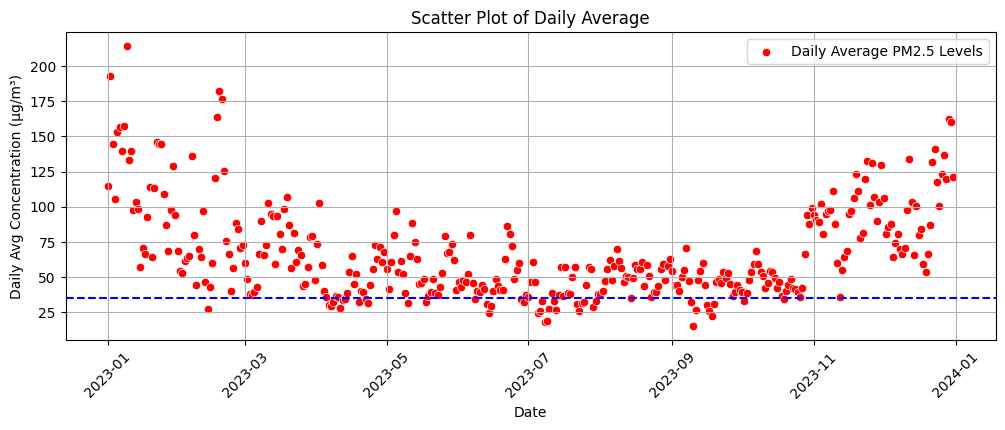

In [29]:
df_date = df.copy()

df_date["date"] = df["time"].dt.date
pollutant = "pm2_5"
df_24_hours = df_date.groupby("date")["pm2_5"].mean().reset_index()

# Plot the scatterplot on a daily basis along with the depiction of threshold value for PM2.5
plt.figure(figsize=(12, 4))
sns.scatterplot(x="date", y=pollutant, data=df_24_hours, color="red", label=f"Daily Average PM2.5 Levels")
threshold = 35
plt.axhline(y=threshold, color="blue", linestyle="--", label=f"Threshold µg/m³)")

plt.title(f"Scatter Plot of Daily Average")
plt.xlabel("Date")
plt.ylabel(f"Daily Avg Concentration (µg/m³)")
plt.grid(True)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)
plt.show()

##### Saving into DB the correct CSV file

In [30]:
save_data_into_dbms(df, "air_quality_transformed", True)

Successfully created table for air quality inside the database


##### Prediction of PM2.5 using Decision Tree

In [31]:
df = df.drop("time", axis=1)

X = df.drop("pm2_5", axis=1)
y = df["pm2_5"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = DecisionTreeRegressor(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R2): {r2:.2f}")

Mean Absolute Error (MAE): 1.85
Mean Squared Error (MSE): 10.52
Root Mean Squared Error (RMSE): 3.24
R-squared (R2): 0.99


##### Prediction of PM2.5 using Random Forest Regressor

In [32]:
X = df.drop("pm2_5", axis=1)
y = df["pm2_5"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R2): {r2:.2f}")

Mean Absolute Error (MAE): 1.21
Mean Squared Error (MSE): 4.05
Root Mean Squared Error (RMSE): 2.01
R-squared (R2): 1.00
